In [17]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from scipy import stats, interpolate, spatial
from IPython.display import HTML
from scipy.io import loadmat
from matplotlib.animation import FuncAnimation
import matplotlib.colors as mcolors
import seaborn as sn
from mpl_toolkits import mplot3d
from itertools import compress
from mpl_toolkits.mplot3d import Axes3D
import random
import multiprocessing
from joblib import Parallel, delayed
import os
from pathlib import Path
NumThread = (multiprocessing.cpu_count() - 1) * 2
import pickle
from multiprocessing import cpu_count, Pool
import glob
from scipy.spatial.distance import cdist


In [18]:
T = 4
scale = 0.008

In [19]:
res = np.load('/mnt/home/mplomecka/saccades/data/postprocessing/data/results.npy', allow_pickle=True).item()

all_ftles = {(T, scale): res}
vc = all_ftles[(T, scale)]['vc']
ly_ids = all_ftles[(T, scale)]['ly_ids']

#Austin's function :
def unpackvcs(vcs, ids):
    unpacked = []
    trial = []
    for i in range(len(ids)):
        if i == 0:
            trial.append(vcs[:, i])
        elif ids[i] == ids[i - 1]:
            trial.append(vcs[:, i])
        else:
            unpacked.append(np.array(trial))
            trial = []
            trial.append(vcs[:, i])
        if i == len(ids) - 1:
            unpacked.append(np.array(trial))
    return unpacked

embedded_traj = unpackvcs(vc, ly_ids)

sanity checks:

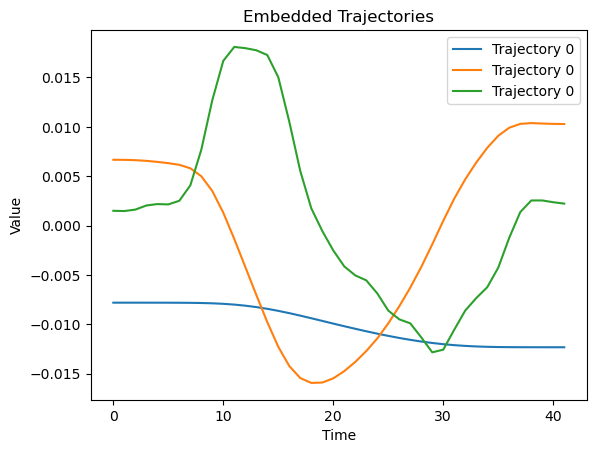

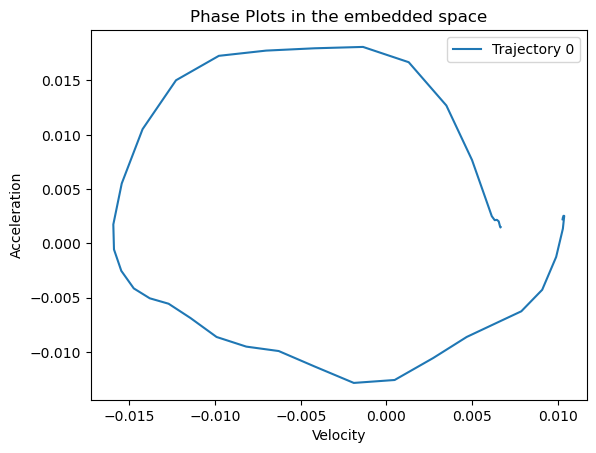

In [20]:
num_to_plot = 1

for i, traj in enumerate(embedded_traj[:num_to_plot]):
    plt.plot(traj, label=f'Trajectory {i}')

plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Embedded Trajectories')
plt.legend()
plt.show()


for i, traj in enumerate(embedded_traj[:num_to_plot]):
    velocity = traj[:, 1]  # Second vec (velocity)
    acceleration = traj[:, 2]  # Third vec (acceleration)
    plt.plot(velocity, acceleration, label=f'Trajectory {i}')

plt.xlabel('Velocity')
plt.ylabel('Acceleration')
plt.title('Phase Plots in the embedded space')
plt.legend()
plt.show()


1. Calculating Peak Points: ectract the peak points (velocity and acceleration) for each trajectory.
2.  Calculating Distances:  pairwise distances between these peak points. we get matrix where each element (i, j) represents the distance between the peak points of trajectories i and j.
3. Ignoring Self-Pairs: Since the distance from a trajectory to itself is 0, the diagonal elements of the distance matrix are filled with infinity using np.fill_diagonal(distances, np.inf), ensuring that they won't be selected as the closest pairs.
4. Closest and Furthest Pairs: By using np.argsort, the code sorts the distances and extracts the indices of the 10 smallest and 10 largest distances. These correspond to the 10 closest and 10 furthest pairs of trajectories, respectively

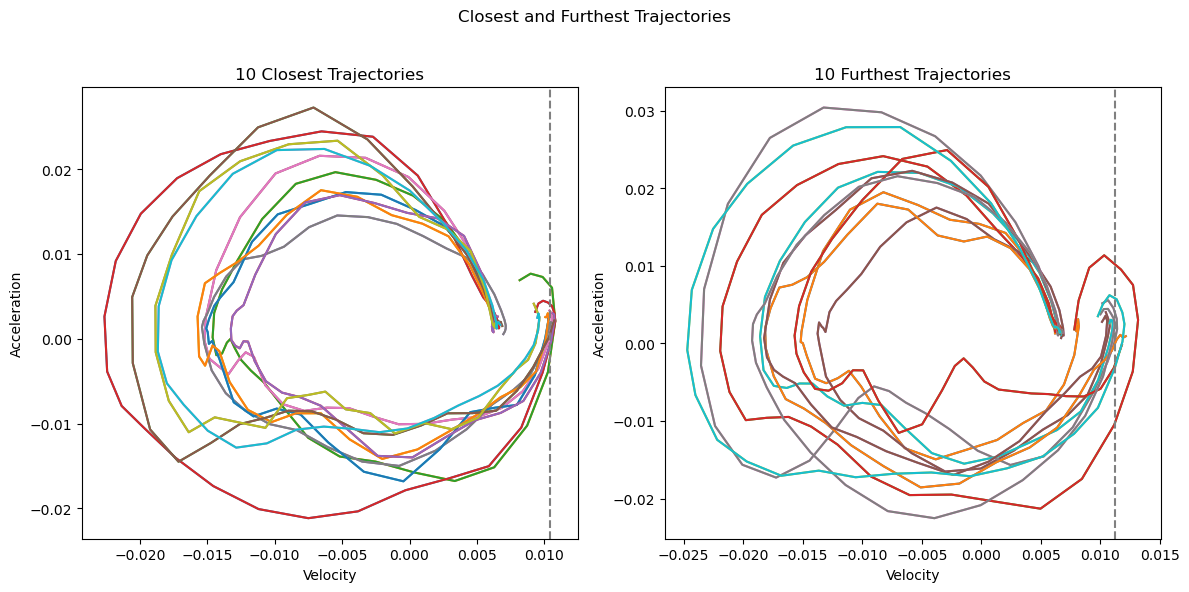

In [21]:
def mean_peak_velocity(indices):
    velocities = [embedded_traj[i][np.argmax(embedded_traj[i][:, 1]), 1] for i in indices]
    return np.mean(velocities)

peak_points = np.array([traj[np.argmax(traj[:, 1]), 1:3] for traj in embedded_traj])
distances = cdist(peak_points, peak_points)
np.fill_diagonal(distances, np.inf)

closest_indices = np.unravel_index(np.argsort(distances, axis=None)[:10], distances.shape)
furthest_indices = np.unravel_index(np.argsort(distances, axis=None)[-10:], distances.shape)
closest_indices_flat = np.unique(np.asarray(closest_indices).flatten())
furthest_indices_flat = np.unique(np.asarray(furthest_indices).flatten())

plt.figure(figsize=(12, 6))
plt.suptitle('Closest and Furthest Trajectories')

plt.subplot(1, 2, 1)
for i, j in zip(*closest_indices):
    plt.plot(embedded_traj[i][:, 1], embedded_traj[i][:, 2])
    plt.plot(embedded_traj[j][:, 1], embedded_traj[j][:, 2])
plt.axvline(x=mean_peak_velocity(closest_indices_flat), color='gray', linestyle='--')
plt.xlabel('Velocity')
plt.ylabel('Acceleration')
plt.title('10 Closest Trajectories')

plt.subplot(1, 2, 2)
for i, j in zip(*furthest_indices):
    plt.plot(embedded_traj[i][:, 1], embedded_traj[i][:, 2])
    plt.plot(embedded_traj[j][:, 1], embedded_traj[j][:, 2])
plt.axvline(x=mean_peak_velocity(furthest_indices_flat), color='gray', linestyle='--')
plt.xlabel('Velocity')
plt.ylabel('Acceleration')
plt.title('10 Furthest Trajectories')

plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.show()


3 d version: 
(the distances are calculated based on a 3D representation of the peak points. Specifically, we create a 3D array of peak points using the position, velocity and acceleration)

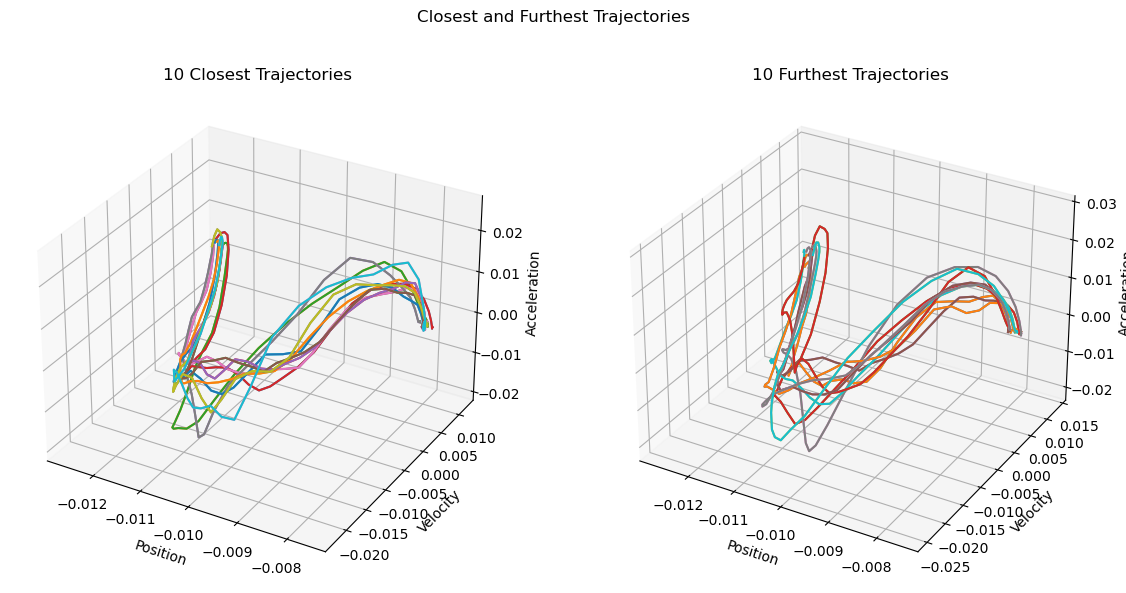

In [22]:
def mean_peak_velocity(indices):
    velocities = [embedded_traj[i][np.argmax(embedded_traj[i][:, 1]), 1] for i in indices]
    return np.mean(velocities)

peak_points = np.array([traj[np.argmax(traj[:, 1]), 0:3] for traj in embedded_traj])
distances = cdist(peak_points, peak_points)
np.fill_diagonal(distances, np.inf)

closest_indices = np.unravel_index(np.argsort(distances, axis=None)[:10], distances.shape)
furthest_indices = np.unravel_index(np.argsort(distances, axis=None)[-10:], distances.shape)
closest_indices_flat = np.unique(np.asarray(closest_indices).flatten())
furthest_indices_flat = np.unique(np.asarray(furthest_indices).flatten())

fig = plt.figure(figsize=(12, 6))
plt.suptitle('Closest and Furthest Trajectories')

# Plotting 10 closest trajectories
ax1 = fig.add_subplot(121, projection='3d')
for i, j in zip(*closest_indices):
    ax1.plot(embedded_traj[i][:, 0], embedded_traj[i][:, 1], embedded_traj[i][:, 2])
    ax1.plot(embedded_traj[j][:, 0], embedded_traj[j][:, 1], embedded_traj[j][:, 2])
ax1.set_xlabel('Position')
ax1.set_ylabel('Velocity')
ax1.set_zlabel('Acceleration')
ax1.set_title('10 Closest Trajectories')

# Plotting 10 furthest trajectories
ax2 = fig.add_subplot(122, projection='3d')
for i, j in zip(*furthest_indices):
    ax2.plot(embedded_traj[i][:, 0], embedded_traj[i][:, 1], embedded_traj[i][:, 2])
    ax2.plot(embedded_traj[j][:, 0], embedded_traj[j][:, 1], embedded_traj[j][:, 2])
ax2.set_xlabel('Position')
ax2.set_ylabel('Velocity')
ax2.set_zlabel('Acceleration')
ax2.set_title('10 Furthest Trajectories')

plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.show()
